<a href="https://colab.research.google.com/github/tort-cam/ST-554-P1/blob/main/Task2/ST554Proj1EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading in the data from UCI and installing modules I'll need.

In [18]:
!pip install ucimlrepo

In [19]:
import numpy as np
import pandas as pd
import math
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn import linear_model
import sklearn.metrics as metrics
import plotly.express as px


In [20]:
air_quality = fetch_ucirepo(id=360)
aq = pd.DataFrame(air_quality.data.features)

##Understanding how this data is stored
This data is almost entirely numeric, with the exception of `Date` and `Time`, and I will convert those to a usable value later. All other columns are either integers or floats.

In [34]:
aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


We were told we can ignore the "True" pollutant measurements, other than Benzene, so I'm removing columns with a "(GT)" in them, other than C6H6 (Benzene)

In [22]:
aq_sub = aq.iloc[:,[0,1,3,5,6,8,10,11,12,13,14]]

taking a look at aq_sub, it seems good! Removed what we don't need.

In [23]:
aq_sub

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,1360,11.9,1046,1056,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,1292,9.4,955,1174,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,1402,9.0,939,1140,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,1376,9.2,948,1092,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1272,6.5,836,1205,1490,1110,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,4/4/2005,10:00:00,1314,13.5,1101,539,1374,1729,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,1163,11.4,1027,604,1264,1269,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,1142,12.4,1063,603,1241,1092,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,1003,9.5,961,702,1041,770,28.3,13.5,0.5139


##Basic Data Validation

Taking a quick peek at what we're working with, using the `.describe()` method.
Looks like there are a lot of -200 values, which represent "missing values"

In [24]:
aq_sub.describe()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1048.990061,1.865683,894.595276,794.990168,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,329.832710,41.380206,342.333252,321.993552,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,921.000000,4.000000,711.000000,637.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1053.000000,7.900000,895.000000,794.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,1221.000000,13.600000,1105.000000,960.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,2040.000000,63.700000,2214.000000,2683.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


##Determine Rate of Missing Values

Let's see how many missing values there are: Looks like we've got ~3300, but only in 366 rows. This suggests that these missing values are often stacked in single rows. Here, `na_ct` will count missing values, while `row_ct` will count the number of rows containing missing values.

In [25]:
na_ct = 0
row_ct = 0
test = False
for row in aq_sub.iloc[:,2:].values:
  test = False
  for val in row:
    if math.isclose(val, -200):
      na_ct+=1
      test = True
  if test:
    row_ct+=1
print (str(na_ct))
print (row_ct)

3294
366


##Clean up data

Okay! Let's replace these -200 values with `NaN` values, and then we can use `.dropna()` to remove them. Our df has gotten 366 rows shorter, the number we were expecting from the last cell's `row_ct` value. I've decided on `aqf` as our dataFrame name, for "Air Quality Fixed". We've also renamed our columns for clarity. Now, let's take another look at `.describe()`

In [26]:
aqtemp = aq_sub.replace(float(-200), np.nan)
aqf = aqtemp.dropna()
print(len(aq_sub)-len(aqf))
aqf = aqf.rename(columns={'C6H6(GT)': 'B', 'PT08.S1(CO)': 'CO', \
                          'PT08.S2(NMHC)': 'NMHC', 'PT08.S3(NOx)': 'NOx', \
                          'PT08.S4(NO2)': 'NO2', 'PT08.S5(O3)': 'O3'})
aqf.describe()

366


,CO,B,NMHC,NOx,NO2,O3,T,RH,AH
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,1099.833166,10.083105,939.153376,835.493605,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,217.080037,7.449820,266.831429,256.817320,346.206794,398.484288,8.832116,17.316892,0.403813
min,647.000000,0.100000,383.000000,322.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,937.000000,4.400000,734.500000,658.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1063.000000,8.200000,909.000000,806.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,1231.000000,14.000000,1116.000000,969.500000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,2040.000000,63.700000,2214.000000,2683.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


Here I am reformatting date and time into a single column for simplicity, and using `datetime` to treat them as a datetime object.

In [27]:
aqf["DTtemp"] = aqf['Date'] + " " + aqf["Time"]
aqf["datetime"] = pd.to_datetime((aqf['DTtemp']), format = 'mixed', dayfirst = False)
aqf = aqf.drop("DTtemp", axis = 1)

##Investigate Distributions

Now that we've cleaned up these missing values, let's get to work! Looks like Benzene (B) is pretty right skewed, with most values being <20.

(array([3.497e+03, 2.899e+03, 1.510e+03, 7.000e+02, 2.540e+02, 9.200e+01,
        2.200e+01, 1.500e+01, 1.000e+00, 1.000e+00]),
 array([ 0.1 ,  6.46, 12.82, 19.18, 25.54, 31.9 , 38.26, 44.62, 50.98,
        57.34, 63.7 ]),
 <BarContainer object of 10 artists>)

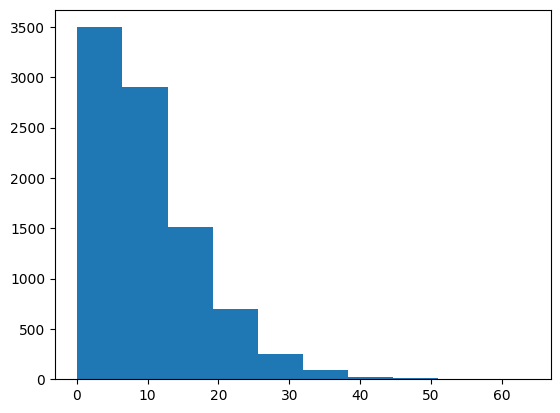

In [28]:
plt.hist(aqf["B"])

Looks like the `datetime` column is working as intended! Noticing a drop in Benzene values around August 2004

Text(0.5, 1.0, 'Benzene levels over time')

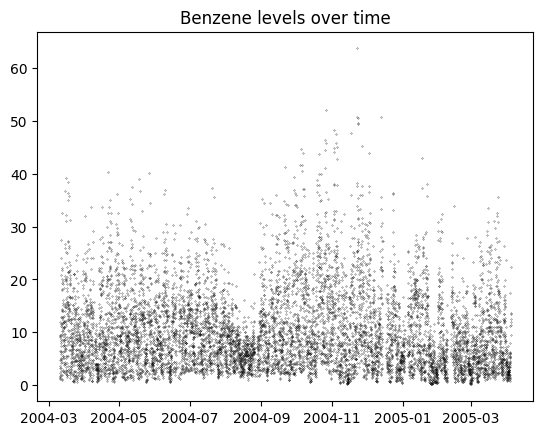

In [29]:
plt.scatter(aqf["datetime"], aqf["B"], s = .05, c = "black")
plt.title("Benzene levels over time")

Here we've got scatter plots of Benzene levels with every other numeric variable, just to get an idea of what our data looks like. Immediately, it seems like Benzene is correlated strongly with CO, NOx, NO2, and O3. NMHC looks a little *too* nice, where it seems like they might be measuring the same thing, just on different scales. I'll need some software math to figure out if temp, relative humidity, or absolute humidity are correlated with Benzene.

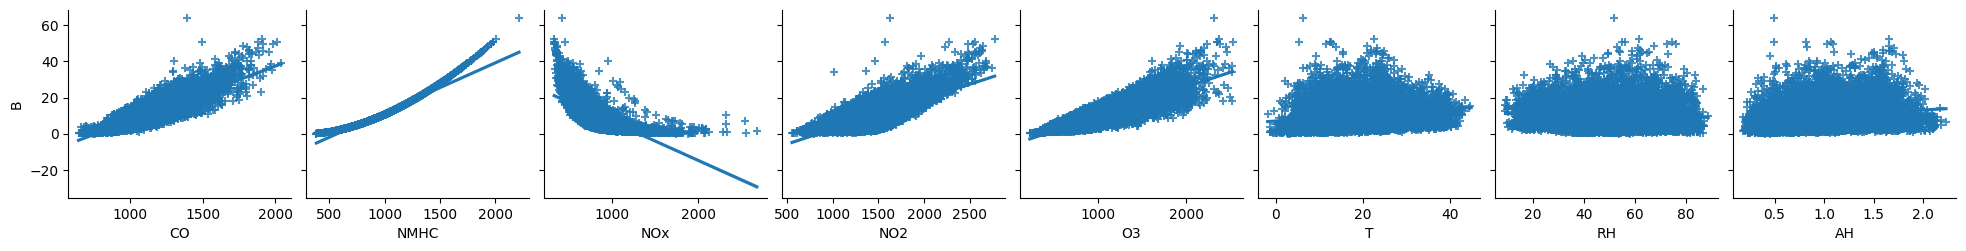

In [30]:
notB = aqf.columns.drop(["B", "Date", "Time", "datetime"])
every = sns.pairplot(kind = "reg", data = aqf, y_vars = "B", x_vars = notB, markers = "+")

Here, I've set the Y axis to `datetime`, showing changes in these variables over the 1 year range. Seems like a lot of the pollution variables drop in August 2004.

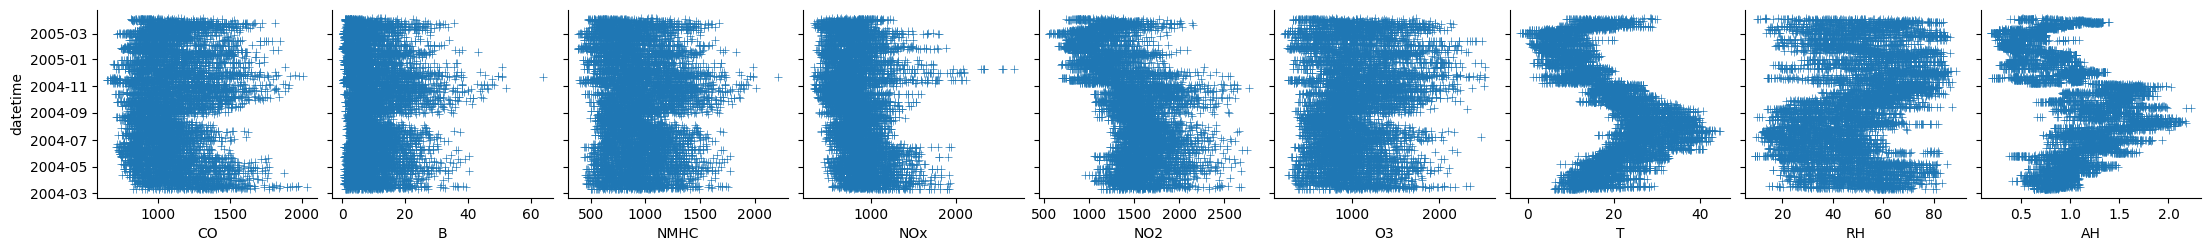

In [31]:
notDT = aqf.columns.drop(["Date", "Time", "datetime"])
every = sns.pairplot(kind = "scatter", data = aqf, y_vars = "datetime", x_vars = notDT, markers = "+")

Let's look at some linear model values!

In [32]:
co = linear_model.LinearRegression()
co.fit(aqf['CO'].values.reshape(-1,1), aqf['B'])
COpred = co.predict(aqf["CO"].values.reshape(-1,1))
print("Linear Model for CO and Benzene", "\nIntercept \t:", co.intercept_, "\nCoefficient\t:", co.coef_, "\nRMSE\t\t:", np.sqrt(metrics.mean_squared_error(aqf["B"], COpred)))

Linear Model for CO and Benzene 
Intercept 	: -23.275221899724677 
Coefficient	: [0.03033035] 
RMSE		: 3.4853845534891


This is a 3D figure of CO, Benzene, and NOx! These variables seem pretty related.

In [33]:
fig = plt.figure()
fig = px.scatter_3d(aqf, x = 'CO', y = 'B', z = 'NOx')
fig.update_traces(marker=dict(size=1))

<Figure size 640x480 with 0 Axes>